In [1]:
import math
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
#from torch.utils.tensorboard import SummaryWriter

In [2]:
def plot_noise_distribution(noise, predicted_noise):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))  # Create three subplots
    
    # Plot GT Noise
    axes[0].plot(noise.cpu().numpy()[0,0], label='GT Noise L', linewidth=0.5, marker='o', markersize=1)
    axes[0].plot(noise.cpu().numpy()[0,1], label='GT Noise R', linewidth=0.5, marker='o', markersize=1)
    axes[0].grid()
    axes[0].legend()
    
    # Plot Predicted Noise
    axes[1].plot(predicted_noise.cpu().numpy()[0,0], label='Pred Noise L', linewidth=0.5, marker='o', markersize=1)
    axes[1].plot(predicted_noise.cpu().numpy()[0,1], label='Pred Noise R', linewidth=0.5, marker='o', markersize=1)
    axes[1].grid()
    axes[1].legend()
    
    # Plot Noise Distribution
    axes[2].hist(noise.cpu().numpy().flatten(), density=True, alpha=0.8, label="Ground Truth Noise")
    axes[2].hist(predicted_noise.cpu().numpy().flatten(), density=True, alpha=0.8, label="Predicted Noise")
    axes[2].legend()
    
    plt.show()

In [3]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """ 
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device="cpu"):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        out = values.gather(-1, t.long().cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [4]:
diffusion_model = DiffusionModel()

In [11]:
'''
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, labels,up=False):
        super().__init__()
        print(f"Block Module - in_ch: {in_ch}, out_ch: {out_ch}")
        
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1,out_ch)
        if up:
            self.conv1 = nn.Conv1d(2 * in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        
        self.bnorm1 = nn.BatchNorm1d(out_ch)
        self.bnorm2 = nn.BatchNorm1d(out_ch)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
     # Remove the last dimension
        x = x.squeeze(2)

    #   First Conv
        print(f"Block Module in_ch before conv1: {x.size(1)}")
        h = self.bnorm1(self.relu(self.conv1(x)))
        print(f" Block Module out_ch after conv1:{h.size(1)}")

    # Time embedding
        time_emb = self.relu(self.time_mlp(t))
    # Extend last dimension
        time_emb = time_emb.unsqueeze(-1)
        # Add time channel
        h = h + time_emb

        if self.labels:
            label = kwargs.get('labels')
            h_label = self.relu(self.label_mlp(label))
            print("h_label:", h_label.shape)

            # Modify unsqueeze operations to match dimensions
            h_label = h_label.unsqueeze(-1).expand_as(h)
            print("--h_label shape before:", h_label.shape)
            print("--h shape before: ", h.shape)
            h = h + h_label
            print(f"--Shape after concatenation: {h.shape}")

            # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        print("Output shape after conv2:", h.shape)

        # Down or Upsample
        h = self.transform(h)

        return h
'''
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
       
        return embeddings
'''
class SimpleUnet(nn.Module):
    def __init__(self,labels=False):
        super().__init__()
        audio_channels = 2  # Adjust for stereo audio
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 2  # Adjust for stereo audio
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv1d(audio_channels, down_channels[0], kernel_size=3, padding=1)  # Adjust here

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim,labels) \
                                    for i in range(len(down_channels) - 1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim,labels) \
                                  for i in range(len(up_channels) - 1)])

        # Output layer
        self.output = nn.Conv1d(up_channels[-1], out_dim, kernel_size=1)

    def forward(self, x, timestep, **kwargs):
        # Embed time
        t = self.time_mlp(timestep)
        print("Input shape before conv0:", x.shape)
        # Initial conv
        x = self.conv0(x)  
        print("Output shape after conv0:", x.shape)
        # Unet
        residual_inputs = []
        for i, down in enumerate(self.downs):
            x = down(x, t, **kwargs)
            print(f"After downsampling block {i} shape:", x.shape)
            residual_inputs.append(x)
        for i, up in enumerate(self.ups):
            residual_x = residual_inputs.pop()
            # Add residual_x as additional channels
            print(f"*Upsampling Block - in_ch before upsample {i}: {x.size(1)}")
            x = torch.cat((x, residual_x), dim=1)
            print(f"*Upsampling Block - out_ch after upsample {i}: {x.size(1)}")
            x = up(x, t, **kwargs)
            print(f"After upsampling block {i} shape:", x.shape)
        # Assuming the final output layer is 1D
        output = self.output(x)
        print("Output shape after self.output:", output.shape)
        return output


# Example usage
##model = SimpleUnet(labels=True)
#print("Num params: ", sum(p.numel() for p in model.parameters()))
#model
'''

'\nclass SimpleUnet(nn.Module):\n    def __init__(self,labels=False):\n        super().__init__()\n        audio_channels = 2  # Adjust for stereo audio\n        down_channels = (64, 128, 256, 512, 1024)\n        up_channels = (1024, 512, 256, 128, 64)\n        out_dim = 2  # Adjust for stereo audio\n        time_emb_dim = 32\n\n        # Time embedding\n        self.time_mlp = nn.Sequential(\n            SinusoidalPositionEmbeddings(time_emb_dim),\n            nn.Linear(time_emb_dim, time_emb_dim),\n            nn.ReLU()\n        )\n\n        # Initial projection\n        self.conv0 = nn.Conv1d(audio_channels, down_channels[0], kernel_size=3, padding=1)  # Adjust here\n\n        # Downsample\n        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim,labels)                                     for i in range(len(down_channels) - 1)])\n        # Upsample\n        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim,labels)

In [5]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters=3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)  # Adjust or replace for audio
        self.labels = labels
        
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv1d(channels_in, channels_out, num_filters, padding=1)  # Change to 1D convolution
            self.final = nn.Conv1d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv1d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose1d(channels_out, channels_out, 4, 2, 1)
            
        self.bnorm1 = nn.BatchNorm1d(channels_out)  # Change to 1D batch normalization
        self.bnorm2 = nn.BatchNorm1d(channels_out)
        
        self.conv2 = nn.Conv1d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time.unsqueeze(2)  # Adjust for 1D data
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label.unsqueeze(2)  # Adjust for 1D data
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

class UNet(nn.Module):
    def __init__(self, audio_channels=2, time_embedding_dims=128, labels=False, sequence_channels=(64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels, downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv1d(audio_channels, sequence_channels[0], 3, padding=1)  # Change to 1D convolution
        self.conv2 = nn.Conv1d(sequence_channels[0], audio_channels, 1)

    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
data_directory = '/nas/home/jalbarracin/datasets/hrir_st'
# Load all audio data into a list
all_left_data = []
all_right_data = []
for filename in os.listdir(data_directory):
    file_path = os.path.join(data_directory, filename)
    wave, sr = torchaudio.load(file_path, normalize=False)
    all_left_data.append(wave[0].to(dtype=torch.float32))
    all_right_data.append(wave[1].to(dtype=torch.float32))

# Calculate mean and variance for each channel of each audio sample
mean_left = [torch.mean(channel) for channel in all_left_data]
mean_right = [torch.mean(channel) for channel in all_right_data]

std_left = [torch.std(channel) for channel in all_left_data]
std_right = [torch.std(channel) for channel in all_right_data]
#print("right:",std_right)
#print("left:",std_left)

# Normalize each channel of each audio sample with its own mean and std
normalized_dataset = [{'audio': torch.stack([(wave[0] - mean[0]) / std[0], (wave[1] - mean[1]) / std[1]]),
                       'subject_id': int(parts[0][2:]), 'measurement_point': int(parts[-1])}
                      for wave, mean, std, parts in zip(zip(all_left_data, all_right_data),
                                                       zip(mean_left, mean_right), zip(std_left, std_right),
                                                       [os.path.splitext(filename)[0].split('_') for filename in os.listdir(data_directory)])]

Using device: cuda


In [19]:
for sample in normalized_dataset:
    measurement_point = sample['measurement_point']
    print(f"Measurement Point: {measurement_point}")

example_measurement_point = normalized_dataset[0]['measurement_point']
print(type(example_measurement_point))
    
#measurement_points = [sample['measurement_point'] for sample in normalized_dataset]
#print("Measurement Points:", measurement_points)

Measurement Point: 28
Measurement Point: 18
Measurement Point: 13
Measurement Point: 4
Measurement Point: 30
Measurement Point: 3
Measurement Point: 22
Measurement Point: 1
Measurement Point: 27
Measurement Point: 13
Measurement Point: 23
Measurement Point: 11
Measurement Point: 10
Measurement Point: 19
Measurement Point: 15
Measurement Point: 10
Measurement Point: 21
Measurement Point: 7
Measurement Point: 7
Measurement Point: 11
Measurement Point: 29
Measurement Point: 25
Measurement Point: 5
Measurement Point: 19
Measurement Point: 10
Measurement Point: 21
Measurement Point: 17
Measurement Point: 10
Measurement Point: 0
Measurement Point: 27
Measurement Point: 34
Measurement Point: 27
Measurement Point: 24
Measurement Point: 5
Measurement Point: 28
Measurement Point: 1
Measurement Point: 29
Measurement Point: 3
Measurement Point: 23
Measurement Point: 34
Measurement Point: 13
Measurement Point: 30
Measurement Point: 26
Measurement Point: 14
Measurement Point: 34
Measurement Point: 1

In [7]:
def collate_fn(batch):
    """
    Collate function for the DataLoader. Assumes each element in batch is a dictionary with 'audio' and 'measurement_point' keys.
    """
    audio_batch = [item['audio'] for item in batch]
    measurement_point_batch = [item['measurement_point'] for item in batch]
    return {'audio': torch.stack(audio_batch), 'measurement_point': torch.tensor(measurement_point_batch)}

In [8]:
import random

# Set a seed for reproducibility
random.seed(42)

# Shuffle the normalized dataset
random.shuffle(normalized_dataset)

# Define the percentage of data to use for training
train_percentage = 0.8  # 80% for training, 20% for testing

# Calculate the split index
split_index = int(len(normalized_dataset) * train_percentage)

# Split the dataset into training and testing sets
train_dataset = normalized_dataset[:split_index]
test_dataset = normalized_dataset[split_index:]

# Print the sizes of the training and testing sets
print(f"Training set size: {len(train_dataset)} samples")
print(f"Testing set size: {len(test_dataset)} samples")

Training set size: 2476 samples
Testing set size: 620 samples


In [9]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True,collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True,collate_fn=collate_fn)

In [23]:
NO_EPOCHS = 101
PRINT_FREQUENCY = 10
LR = 0.001
VERBOSE = True
unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 0.49702609247631496 | Val Loss 0.42364728450775146


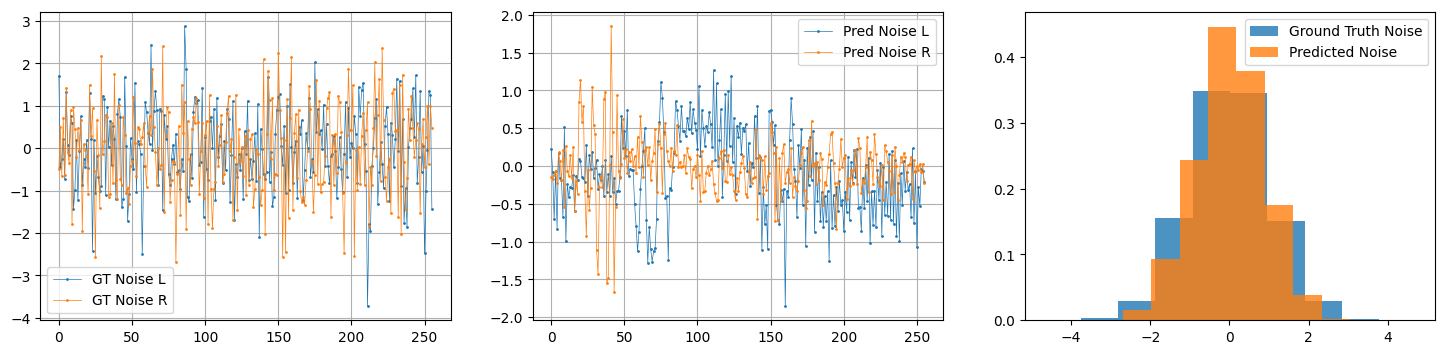

---
Epoch: 10 | Train Loss 0.26736891600820756 | Val Loss 0.2656291276216507


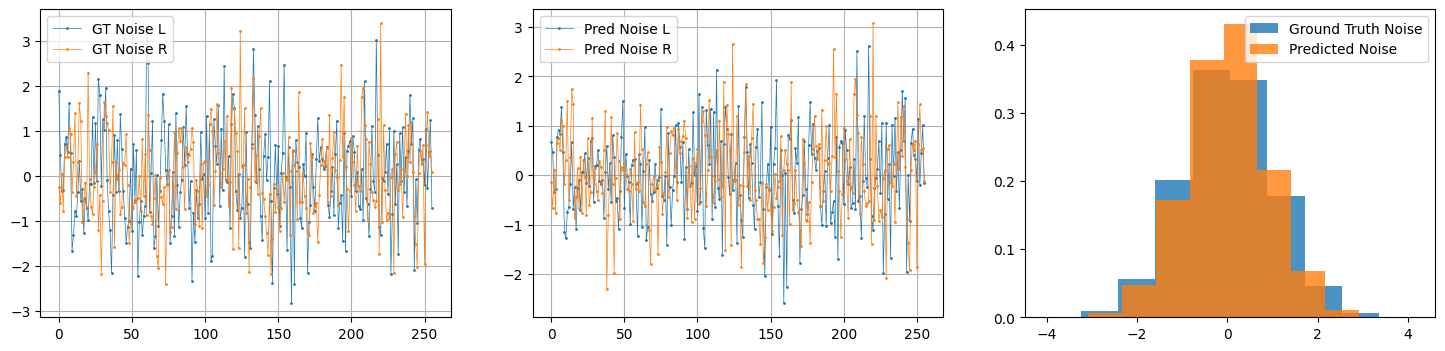

---
Epoch: 20 | Train Loss 0.24466654492749107 | Val Loss 0.24011370539665222


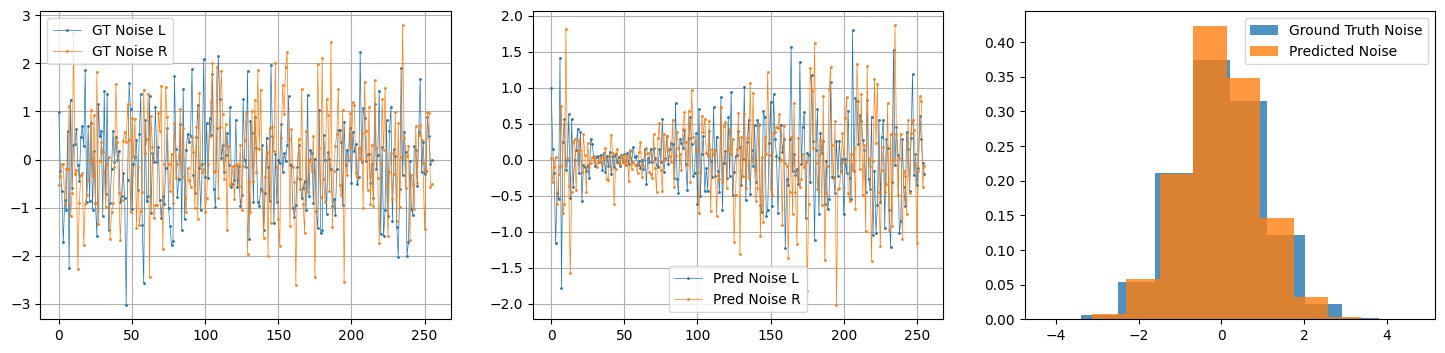

---
Epoch: 30 | Train Loss 0.2323994388182958 | Val Loss 0.23144716024398804


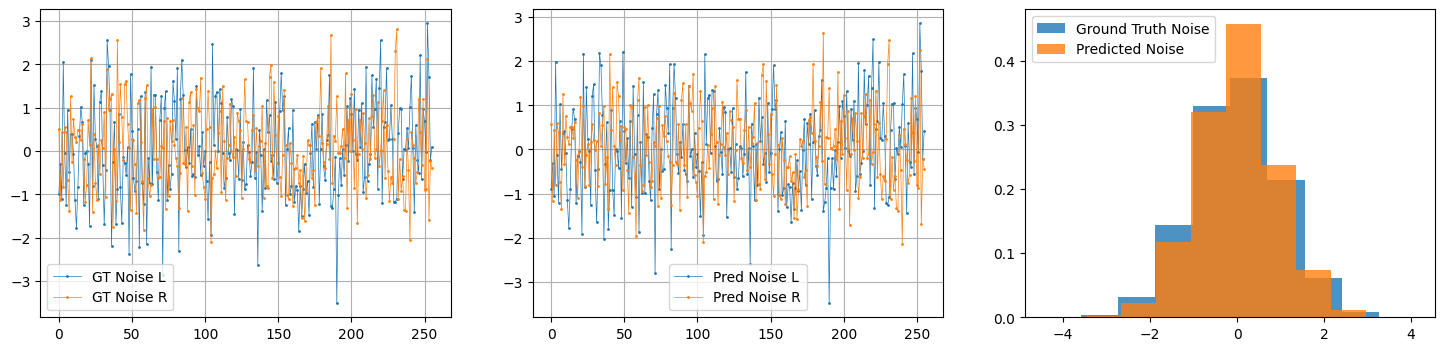

---
Epoch: 40 | Train Loss 0.22622659968005288 | Val Loss 0.22290139645338058


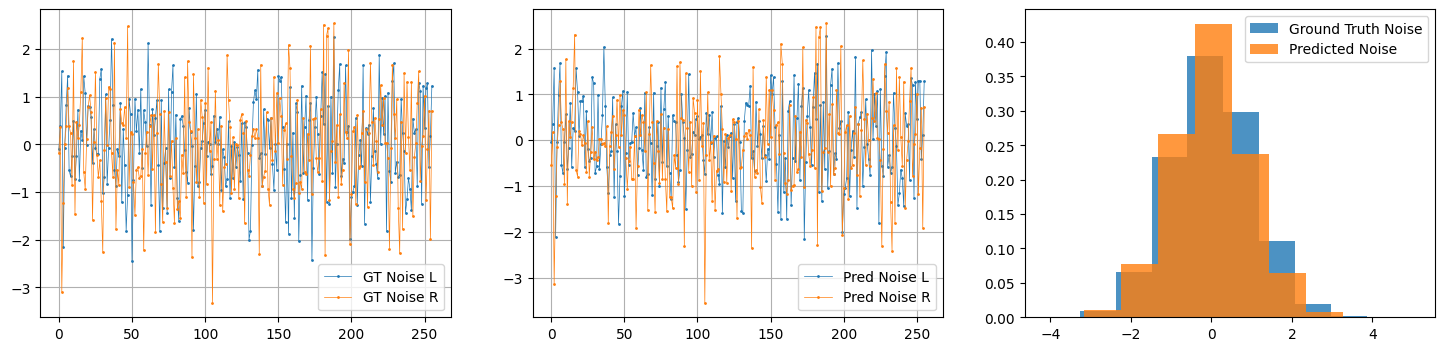

---
Epoch: 50 | Train Loss 0.2133685764339235 | Val Loss 0.2182472199201584


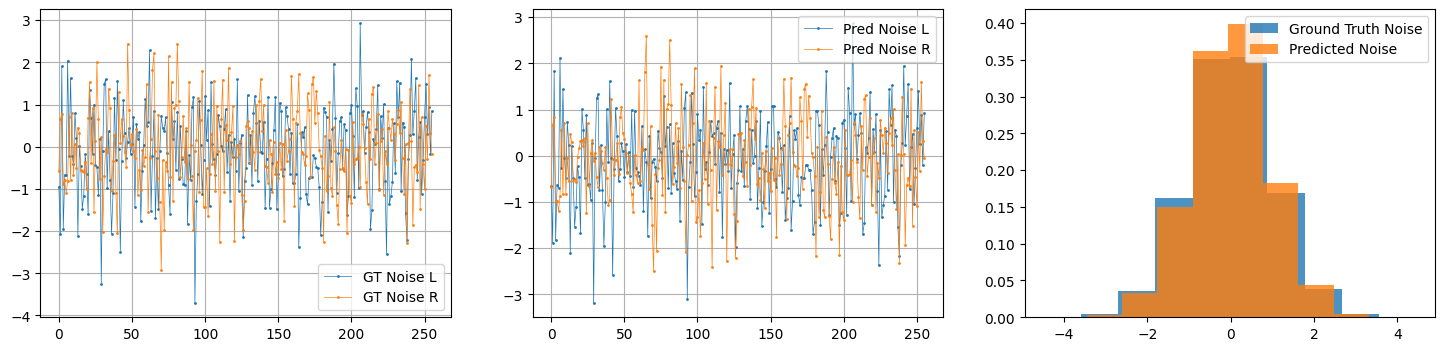

---
Epoch: 60 | Train Loss 0.21487558550304836 | Val Loss 0.20854666084051132


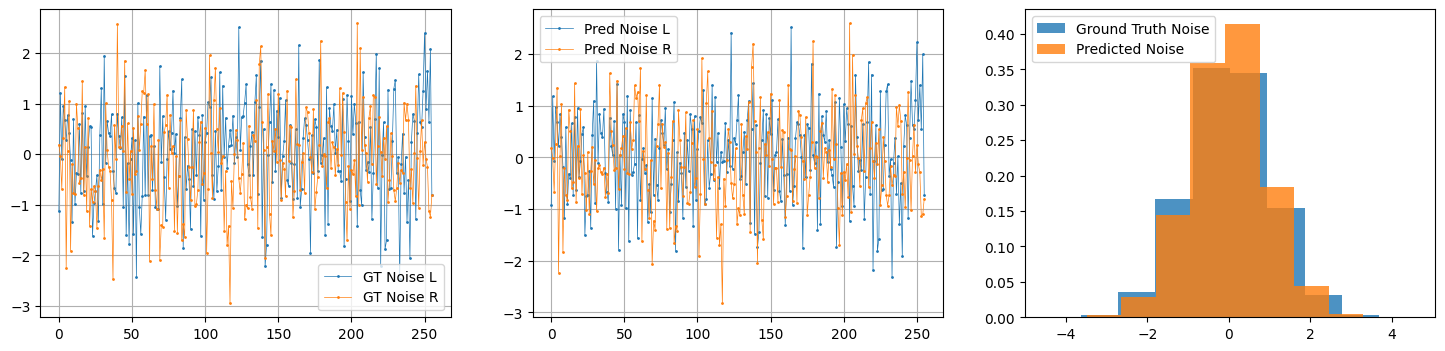

---
Epoch: 70 | Train Loss 0.2081069615152147 | Val Loss 0.21266348659992218


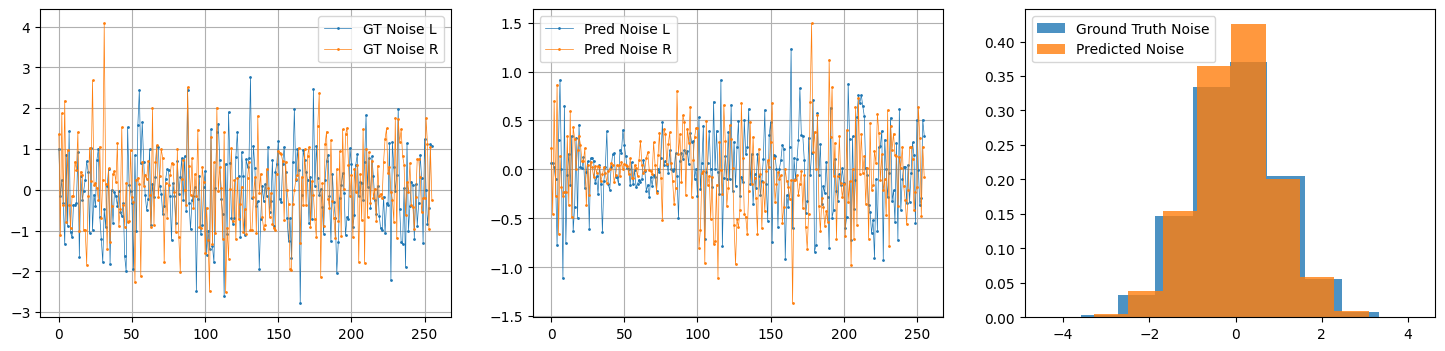

---
Epoch: 80 | Train Loss 0.2125909427801768 | Val Loss 0.21589519828557968


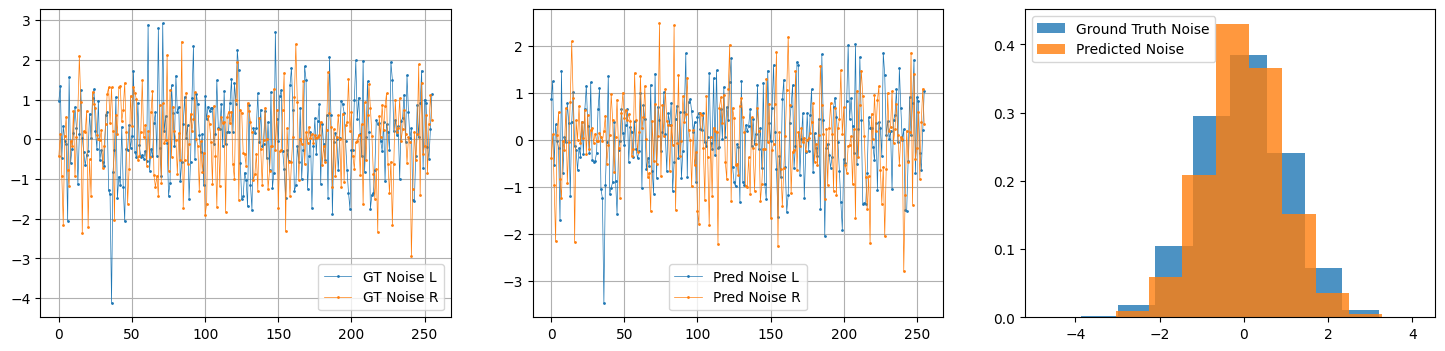

---
Epoch: 90 | Train Loss 0.20383243262767792 | Val Loss 0.2043171375989914


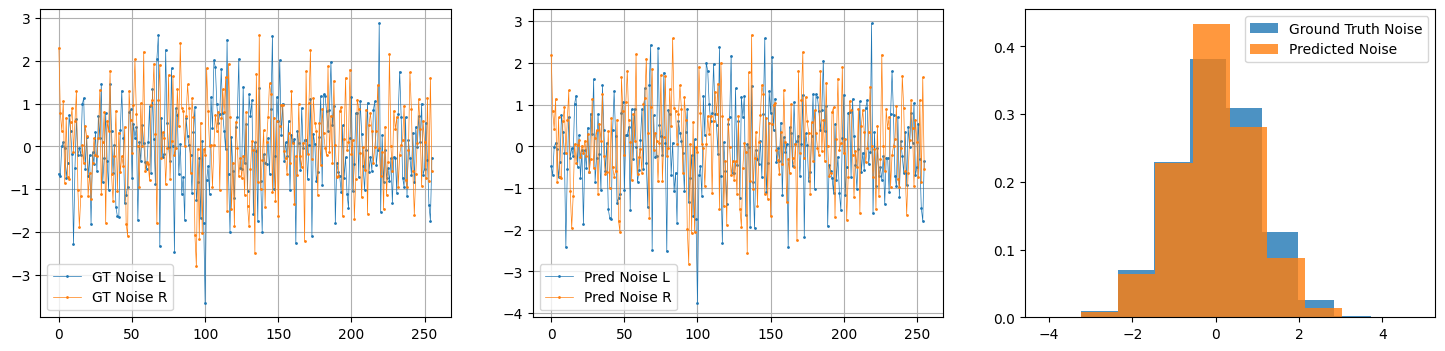

---
Epoch: 100 | Train Loss 0.20332983136177063 | Val Loss 0.19823504984378815


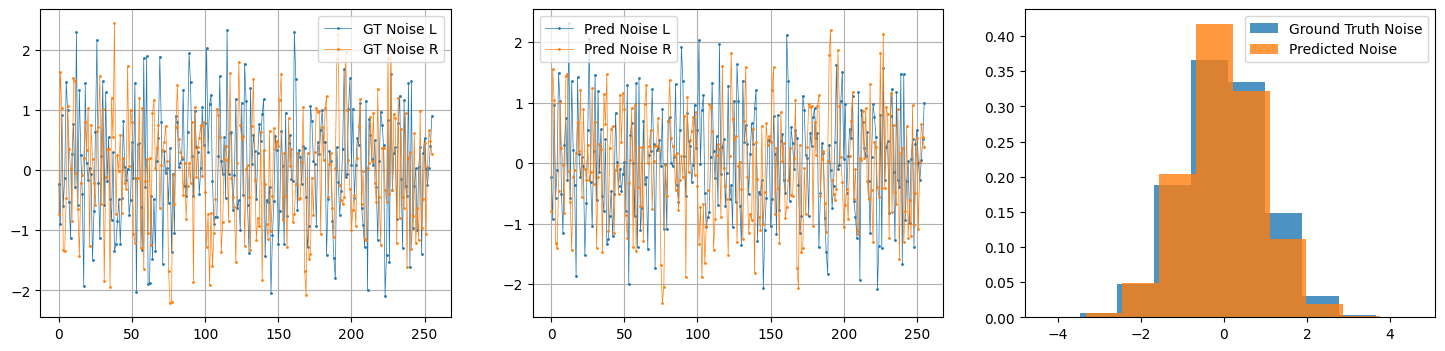

In [26]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    
    for data in train_loader:
        batch = data['audio'].to(device)
        label = data['measurement_point'].to(device).float()  # Cast label to float
        
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).float().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        #print("batch_noisy:", batch_noisy.shape)
        #print("t",t.shape)
        predicted_noise = unet(batch_noisy, t, labels=label.reshape(-1, 1))
        
        optimizer.zero_grad()
        loss = torch.nn.functional.l1_loss(noise, predicted_noise) 
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    for data in test_loader:
        batch = data['audio'].to(device)
        label = data['measurement_point'].to(device).float()  # Cast label to float
        
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).float().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, labels=label.reshape(-1, 1))
        
        loss = torch.nn.functional.l1_loss(noise, predicted_noise) 
        mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        #plot_noise_distribution(noise, predicted_noise)
        if VERBOSE:
            with torch.no_grad():
                plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"epoch: {epoch}")

In [12]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("epoch: 80")))

<All keys matched successfully>

In [28]:
classes = ('0', '5', '10', '15',
           '20', '25', '30', '35')

In [29]:
NUM_CLASSES = 36
NUM_DISPLAY_IMAGES = 5

<Figure size 1500x1500 with 0 Axes>

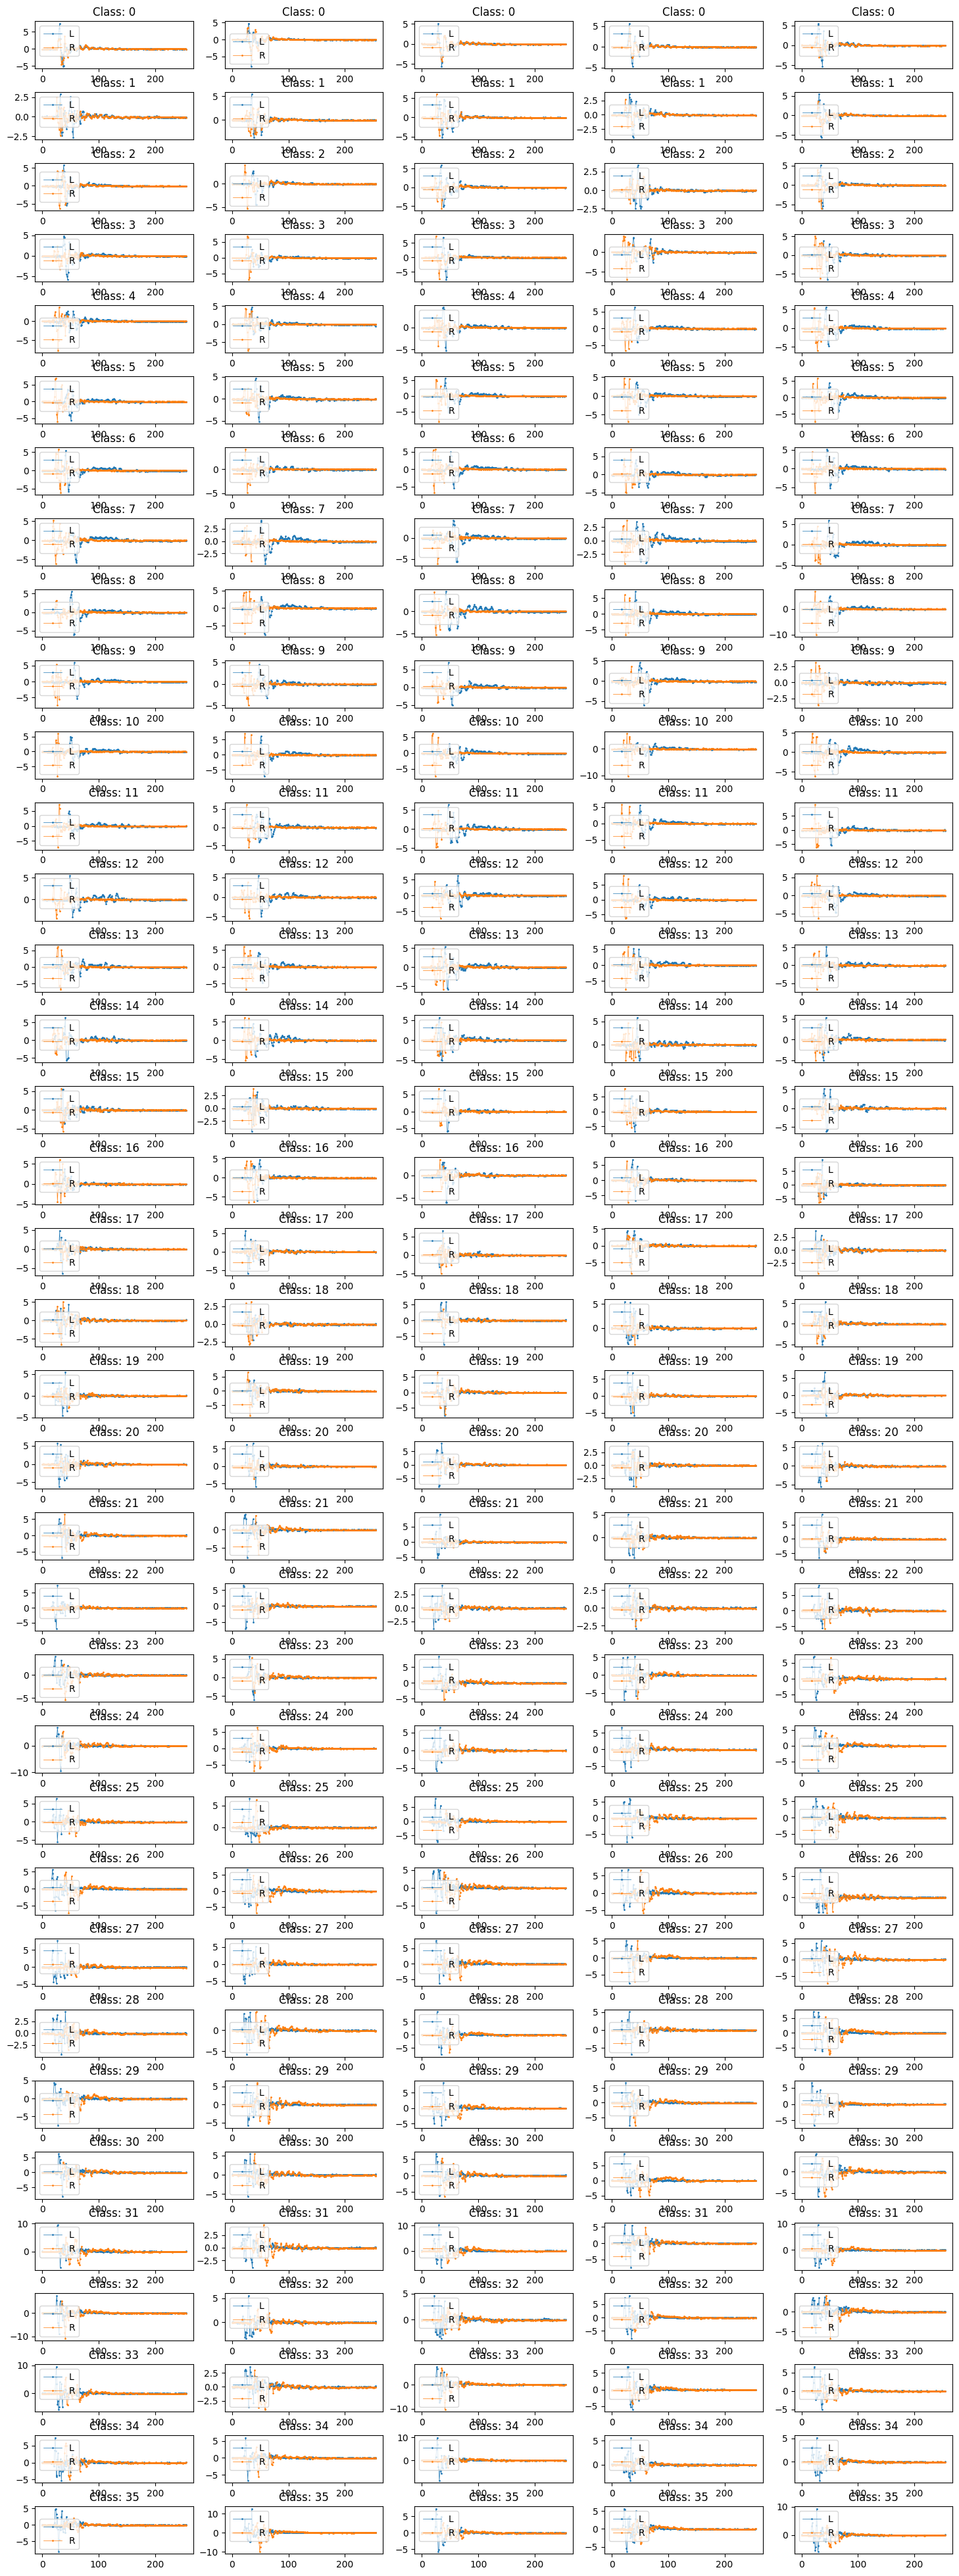

In [30]:
torch.manual_seed(16)
#AUDIO_SIZE = 256
plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (18,50))

for c in range(NUM_CLASSES):
    audio_result = torch.randn((NUM_DISPLAY_IMAGES,) + (2,256)).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        #print("c: ",c)
        audio_result = diffusion_model.backward(x=audio_result, t=t, model=unet.eval().to(device), labels = labels)
    
    for idx, audio in enumerate(audio_result):
        #audio_np = reverse_transform(audio)
        ax[c][idx].plot(audio_result[idx,0].detach().cpu(), label='L',linewidth=0.5, marker='o', markersize=1)
        ax[c][idx].plot(audio_result[idx,1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
        ax[c][idx].legend()
        ax[c][idx].set_title(f"Class: {c}")
        #print(idx)
        
plt.subplots_adjust(hspace=0.5)
#plt.show()

<Figure size 1500x1500 with 0 Axes>

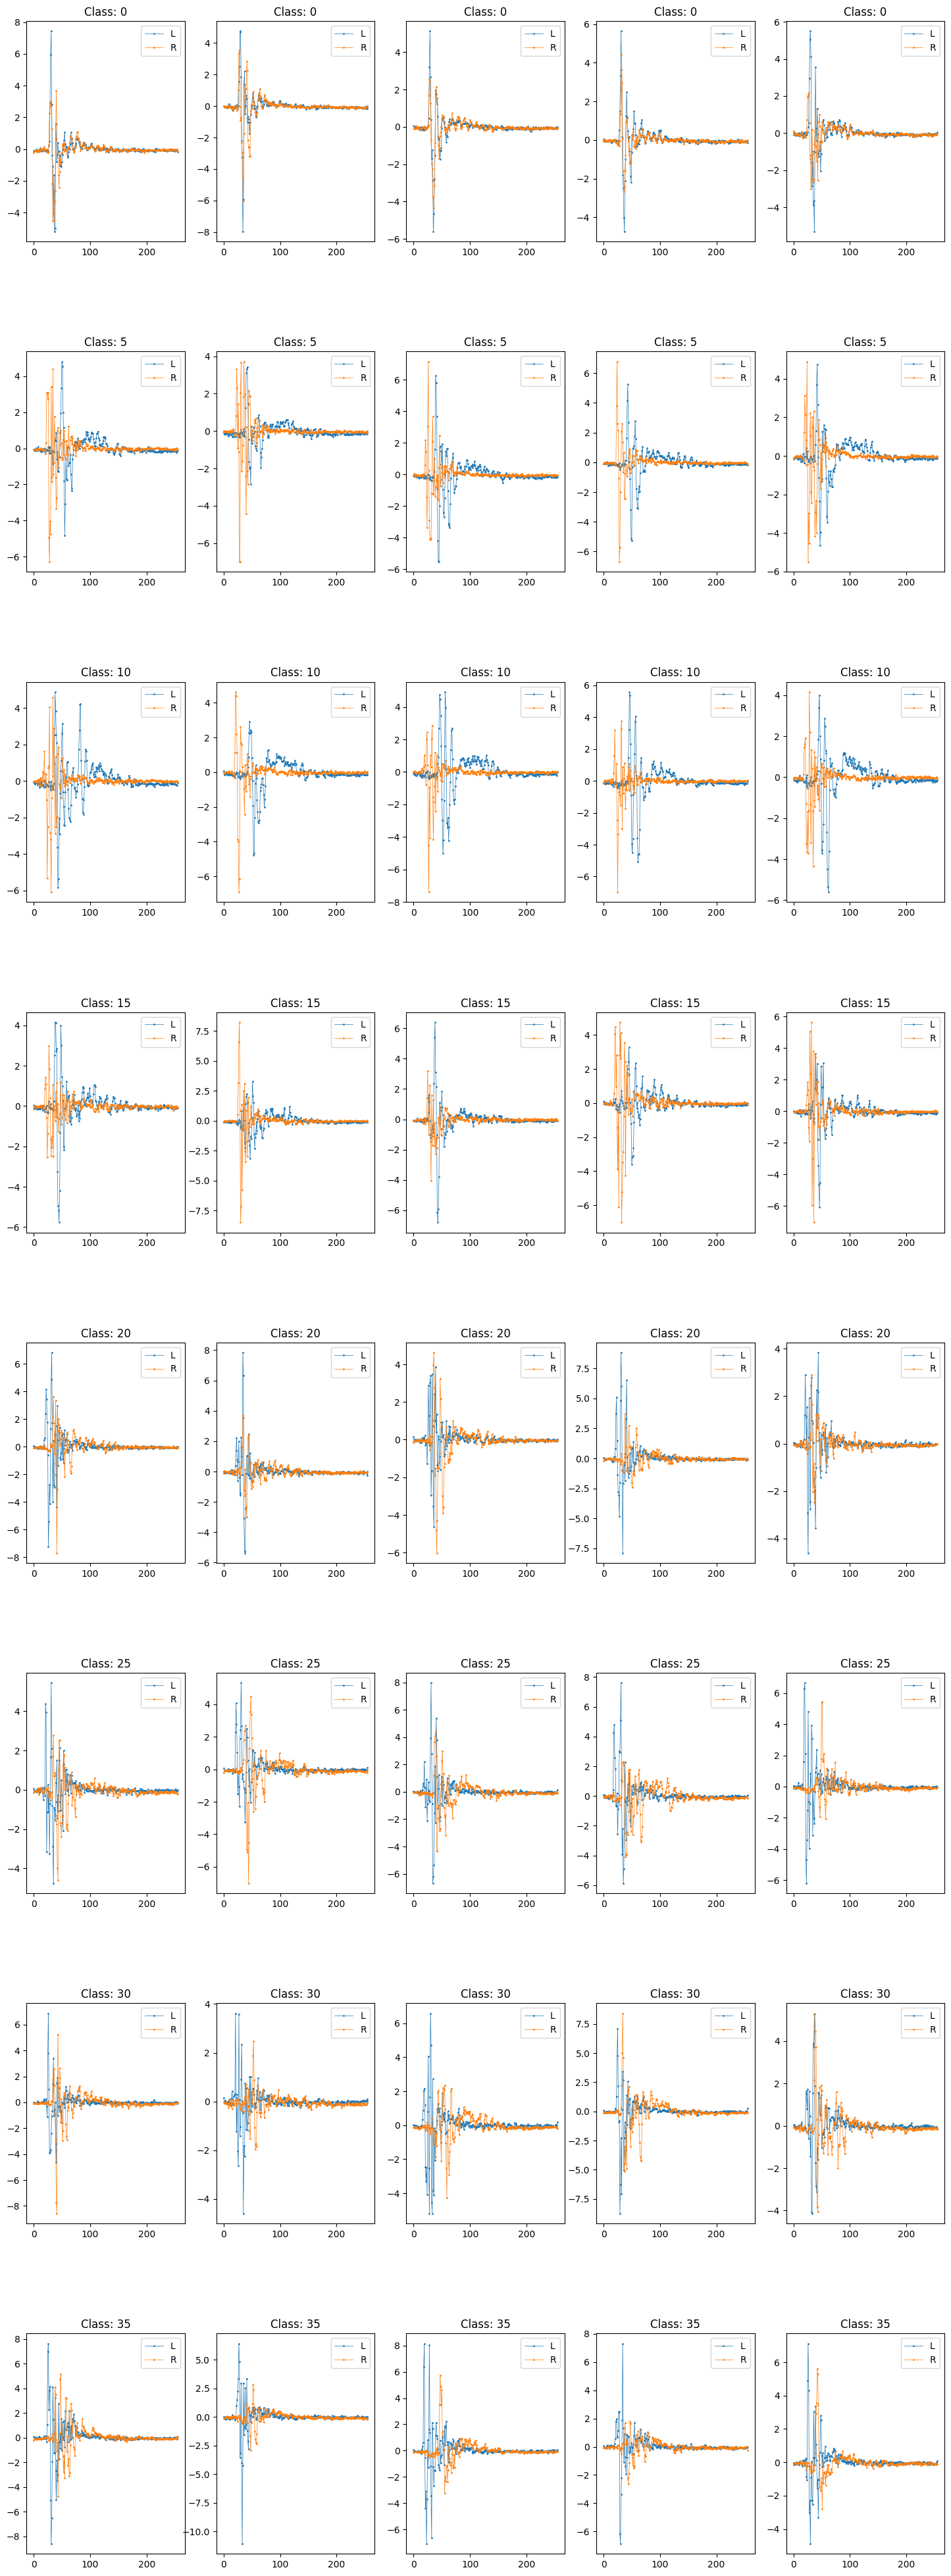

In [25]:
torch.manual_seed(16)
#AUDIO_SIZE = 256
plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (18,50))

for c, class_label in enumerate(classes):  # Enumerate over classes and get the class label
    audio_result = torch.randn((NUM_DISPLAY_IMAGES,) + (2, 256)).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([int(class_label)] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        audio_result = diffusion_model.backward(x=audio_result, t=t, model=unet.eval().to(device), labels=labels)
    
    for idx, audio in enumerate(audio_result):
        ax[c][idx].plot(audio_result[idx, 0].detach().cpu(), label='L', linewidth=0.5, marker='o', markersize=1)
        ax[c][idx].plot(audio_result[idx, 1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
        ax[c][idx].legend()
        ax[c][idx].set_title(f"Class: {class_label}")

plt.subplots_adjust(hspace=0.5)
plt.show()

<Figure size 1500x1500 with 0 Axes>

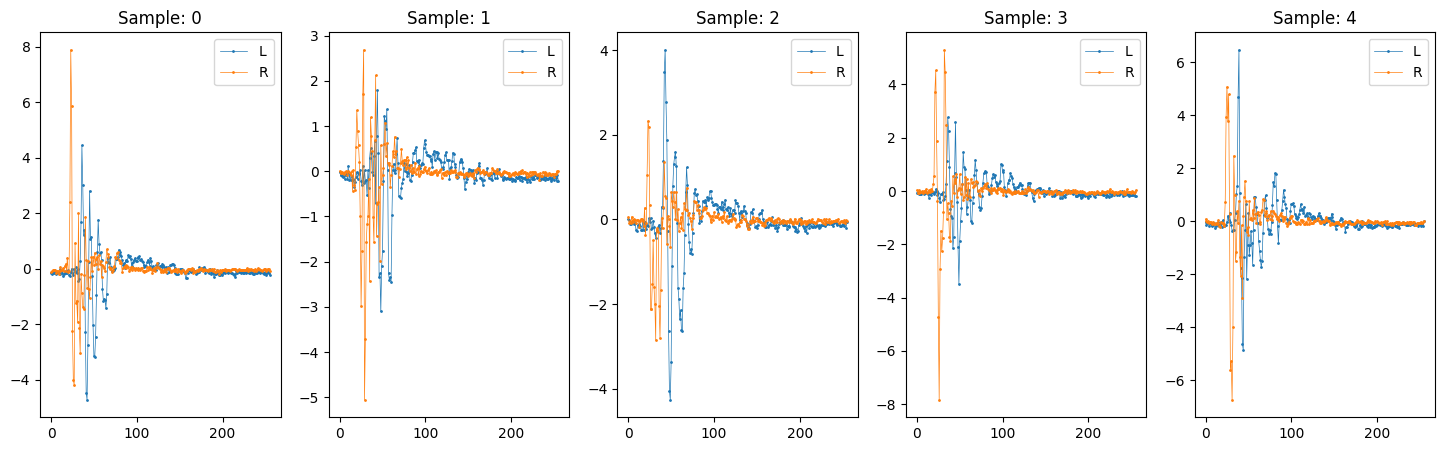

In [43]:
torch.manual_seed(16)
plt.figure(figsize=(15, 15))
f, ax = plt.subplots(1, NUM_DISPLAY_IMAGES, figsize=(18, 5))  # Adjust the number of subplots

# Choose the specific class you want to visualize
class_to_visualize = 4  # Replace with the desired class index

audio_result = torch.randn((NUM_DISPLAY_IMAGES, 2, 256)).to(device)

for i in reversed(range(diffusion_model.timesteps)):
    t = torch.full((1,), i, dtype=torch.long, device=device)
    labels = torch.tensor([class_to_visualize] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
    audio_result = diffusion_model.backward(x=audio_result, t=t, model=unet.eval().to(device), labels=labels)

for idx, audio in enumerate(audio_result):
    ax[idx].plot(audio_result[idx, 0].detach().cpu(), label='L', linewidth=0.5, marker='o', markersize=1)
    ax[idx].plot(audio_result[idx, 1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
    ax[idx].legend()
    ax[idx].set_title(f"Sample: {idx}")

plt.subplots_adjust(hspace=0.5)
plt.show()


Text(0.5, 1.0, 'Denoised')

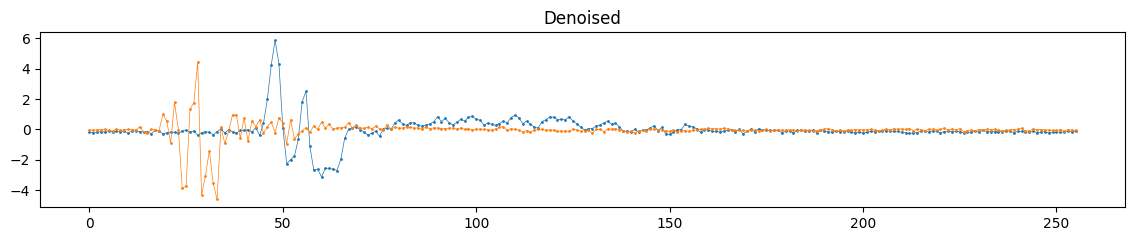

In [51]:
# Plot the first stereo audio file
plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(audio_result[4,0].detach().cpu(),label='L', linewidth=0.5, marker='o', markersize=1)
plt.plot(audio_result[4,1].detach().cpu(),label='R', linewidth=0.5, marker='o', markersize=1)
plt.title('Denoised')

<Figure size 1500x1500 with 0 Axes>

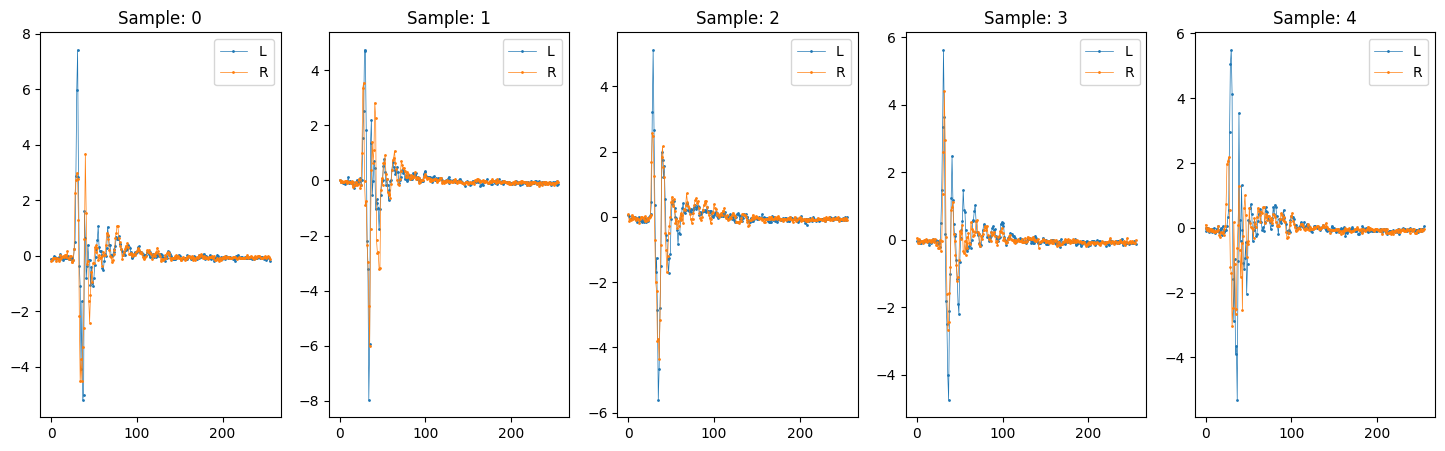

In [46]:
torch.manual_seed(16)
plt.figure(figsize=(15, 15))
f, ax = plt.subplots(1, NUM_DISPLAY_IMAGES, figsize=(18, 5))  # Adjust the number of subplots

# Choose the specific class you want to visualize
class_to_visualize = 0  # Replace with the desired class index

audio_result = torch.randn((NUM_DISPLAY_IMAGES, 2, 256)).to(device)

for i in reversed(range(diffusion_model.timesteps)):
    t = torch.full((1,), i, dtype=torch.long, device=device)
    labels = torch.tensor([class_to_visualize] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
    audio_result = diffusion_model.backward(x=audio_result, t=t, model=unet.eval().to(device), labels=labels)

for idx, audio in enumerate(audio_result):
    ax[idx].plot(audio_result[idx, 0].detach().cpu(), label='L', linewidth=0.5, marker='o', markersize=1)
    ax[idx].plot(audio_result[idx, 1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
    ax[idx].legend()
    ax[idx].set_title(f"Sample: {idx}")

plt.subplots_adjust(hspace=0.5)
plt.show()